In [86]:
import requests
import json

# Define the URL of the API endpoint
url = "https://dfwsa.deepflow.in/api/data/list/?limit=40000"

# Send a GET request to the API endpoint
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # If successful, you can access the data from the response
    api_data = response.json()

    # Extract specific fields
    selected_data = {key: api_data[key] for key in ["count", "next", "previous", "results"]}

    # Do something with the selected data, such as saving it to a file
    with open("weather_data_tata_selected.json", "w") as file:
        file.write(json.dumps(selected_data))

    print("Selected data downloaded successfully.")
else:
    # If the request was unsuccessful, print an error message
    print("Error:", response.status_code)


Selected data downloaded successfully.


In [68]:
import json
import pandas as pd

# Load the weather data from the JSON file
with open('weather_data_tata_selected.json', 'r') as f:
    data_str = f.read()

# Convert the JSON string to a Python object
data = json.loads(data_str)

# Extract 'results' from the data
weather_data = data.get('results', [])

# Create a list of dictionaries where each dictionary represents a data point
data_list = []
for entry in weather_data:
    data_point = {
        'Timestamp': entry.get('time'),
        'rainfall': entry.get('rainfall'),
        'temperature': entry.get('temperature'),
        'pressure': entry.get('pressure'),
        'Direction': entry.get('direction'),
        'humidity': entry.get('humidity'),
        'speed': entry.get('speed'),
        'lux': entry.get('lux'),
        'Angle': entry.get('angle')
    }
    data_list.append(data_point)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)
# Reverse the order of rows
df = df[::-1].reset_index(drop=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

# # Filter data from 5 PM, 22nd February onwards
# start_time = pd.Timestamp('2024-02-23 06:21:00')
# df_filtered = df[df.index >= start_time]

# # Display the filtered DataFrame
# df = df_filtered.copy()
df

,rainfall,temperature,pressure,Direction,humidity,speed,lux,Angle
Timestamp,,,,,,,,
2024-02-22 17:00:01.318240,0.0,27.14,901.97,8.0,45.01,0.0,6752.10,183.0
2024-02-22 17:00:03.098218,0.0,27.15,901.97,8.0,45.23,0.0,6790.35,183.0
2024-02-22 17:00:04.878026,1.8,27.16,901.98,8.0,45.43,0.0,6767.77,183.0
2024-02-22 17:00:06.658391,1.8,27.17,901.98,8.0,45.33,0.0,6753.95,183.0
2024-02-22 17:00:08.460353,1.8,27.17,901.98,8.0,45.37,0.0,6755.79,183.0
...,...,...,...,...,...,...,...,...
2024-03-01 22:08:34.191819,0.0,20.05,905.65,12.0,100.00,0.0,0.00,277.7
2024-03-01 22:08:35.992363,0.0,20.05,905.64,12.0,100.00,0.0,0.00,277.7
2024-03-01 22:08:37.751369,0.0,20.05,905.65,12.0,100.00,0.0,0.00,277.7


<Axes: xlabel='Timestamp'>

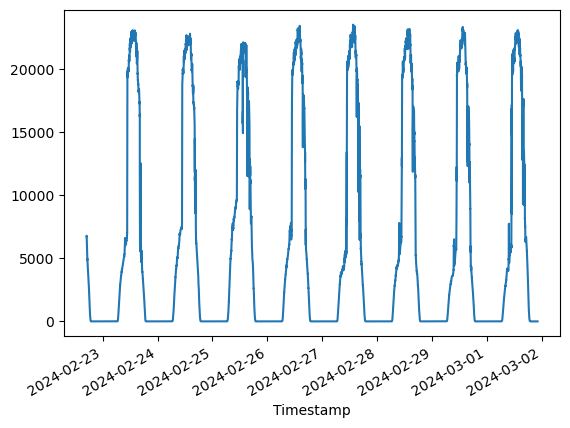

In [2]:
df.lux.plot()

In [3]:
import pandas as pd

# Assuming your data is in a DataFrame named 'df' with the 'Timestamp' as the index
# and 'lux' column for light intensity

# Convert the index to datetime
df.index = pd.to_datetime(df.index)

# Calculate time differences
df['time_diff'] = df.index.to_series().diff()

# Function to get the total light duration for a day
def get_light_duration(group):
    light_mask = group['lux'] > 1
    group['light_duration'] = group['time_diff'].where(light_mask, pd.Timedelta(0)).cumsum()
    return group['light_duration'].iloc[-1]

# Function to get the total day duration for a day
def get_total_duration(group):
    group['total_duration'] = group['time_diff'].cumsum()
    return group['total_duration'].iloc[-1]

# Group by date and apply the functions
daily_light_duration = df.groupby(df.index.date).apply(get_light_duration)
daily_total_duration = df.groupby(df.index.date).apply(get_total_duration)

# Calculate the duration of no light
daily_no_light_duration = daily_total_duration - daily_light_duration

# Create a DataFrame with the results
result_df = pd.DataFrame({
    'Date': daily_light_duration.index,
    'Light_Duration': daily_light_duration.dt.total_seconds() / 3600,  # Convert to hours
    'No_Light_Duration': daily_no_light_duration.dt.total_seconds() / 3600  # Convert to hours
}).reset_index(drop=True)  # Reset index to remove duplicate date column

# Function to format duration in hours to "hours:minutes:seconds" format
def format_duration(duration_hours):
    minutes, seconds = divmod(duration_hours * 3600, 60)
    hours, minutes = divmod(minutes, 60)
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"

# Apply the formatting function to the DataFrame
result_df['Light_Duration'] = result_df['Light_Duration'].apply(format_duration)
result_df['No_Light_Duration'] = result_df['No_Light_Duration'].apply(format_duration)

# Apply bold style to the DataFrame, but only for the specified columns
styled_df = result_df.style.applymap(lambda x: 'font-weight: bold', subset=pd.IndexSlice[:, ['Date', 'Light_Duration', 'No_Light_Duration']])

# Display the styled DataFrame
styled_df


,Date,Light_Duration,No_Light_Duration
0,2024-02-22,01:54:43,04:59:11
1,2024-02-23,12:31:17,11:33:51
2,2024-02-24,12:31:16,11:27:28
3,2024-02-25,12:37:39,11:21:06
4,2024-02-26,12:37:37,11:21:10
5,2024-02-27,12:37:38,11:21:08
6,2024-02-28,12:37:39,11:27:29
7,2024-02-29,12:37:40,11:21:06
8,2024-03-01,12:31:15,09:39:17


# Weekly Trend {min and max}

In [7]:
df.drop(columns=['time_diff'], inplace=True)

In [8]:
from IPython.display import display, HTML
min_values = df.min()
max_values = df.max()
result = pd.concat([min_values, max_values], axis=1)
result.columns = ['Min', 'Max']

# Convert to HTML to include bold formatting
result_html = result.to_html().replace('<td>', '<td style="font-weight:bold">')

# Display the HTML-formatted result in the notebook
display(HTML(result_html))


,Min,Max
rainfall,0.00,1.80
temperature,16.80,34.86
pressure,899.72,906.96
Direction,0.00,16.00
humidity,15.20,100.00
speed,0.00,4.00
lux,0.00,23530.75
Angle,0.50,360.00


# Daliy Trend {min and max}

In [9]:
import pandas as pd

# Assuming your DataFrame is named 'df' and the Timestamp column is set as the index
# If not, you can set it using df.set_index('Timestamp', inplace=True)

# Convert the Timestamp to the date only
df.index = pd.to_datetime(df.index).date

# Group by date and find min and max for each column
min_values = df.groupby(df.index).min()
max_values = df.groupby(df.index).max()

# Display the results in bold and DataFrame format
print("\033[1mMinimum values:\033[0m")
pd.DataFrame(min_values)

Minimum values:


,rainfall,temperature,pressure,Direction,humidity,speed,lux,Angle
2024-02-22,0.0,17.83,901.97,6.0,44.96,0.0,0.0,140.4
2024-02-23,0.0,16.86,901.25,1.0,24.89,0.0,0.0,26.2
2024-02-24,0.0,16.80,901.54,0.0,32.07,0.0,0.0,9.2
2024-02-25,0.0,17.78,899.72,0.0,28.98,0.0,0.0,1.0
2024-02-26,0.0,17.99,900.62,0.0,25.86,0.0,0.0,2.0
2024-02-27,0.0,17.07,901.34,0.0,32.21,0.0,0.0,0.5
2024-02-28,0.0,17.62,900.26,0.0,23.67,0.0,0.0,0.5
2024-02-29,0.0,17.26,901.04,0.0,15.56,0.0,0.0,0.5
2024-03-01,0.0,17.66,901.89,0.0,15.20,0.0,0.0,0.5


In [10]:
print("\n\033[1mMaximum values:\033[0m")
pd.DataFrame(max_values)


Maximum values:


,rainfall,temperature,pressure,Direction,humidity,speed,lux,Angle
2024-02-22,1.8,27.27,905.27,13.0,96.56,0.8,6790.35,291.6
2024-02-23,1.8,34.77,906.25,14.0,98.91,3.1,23097.60,320.4
2024-02-24,0.0,33.18,905.80,16.0,98.31,2.1,22814.67,360.0
2024-02-25,0.0,34.86,905.09,16.0,100.00,3.1,22133.14,356.4
2024-02-26,0.0,32.21,905.22,16.0,95.41,3.8,23441.36,360.0
2024-02-27,0.0,33.62,905.74,16.0,94.39,3.8,23530.75,360.0
2024-02-28,0.0,33.70,905.53,16.0,94.75,3.3,23192.06,360.0
2024-02-29,0.0,34.45,905.58,16.0,100.00,3.1,23342.29,360.0
2024-03-01,0.0,33.55,906.96,16.0,100.00,4.0,23097.14,360.0


# min and max plot with daily trend

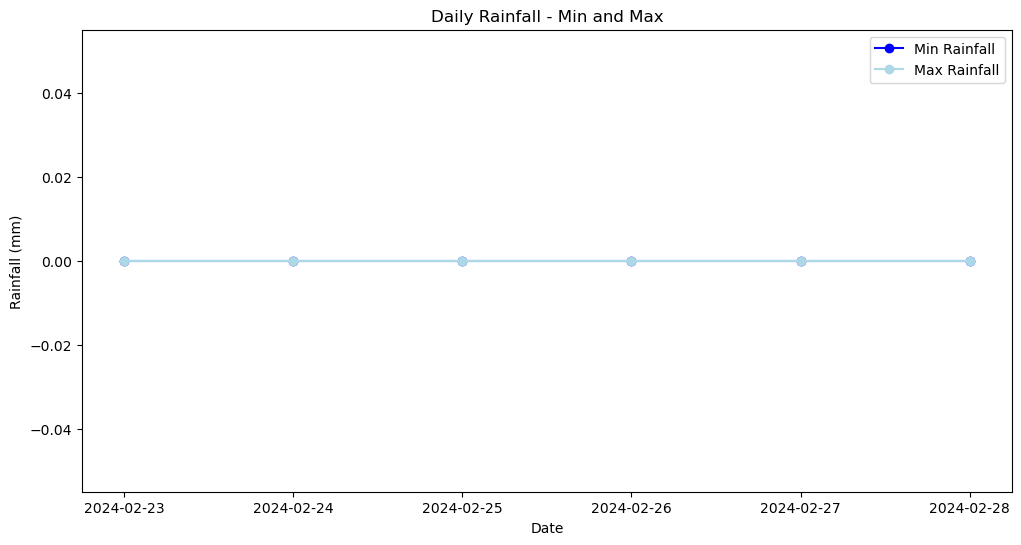

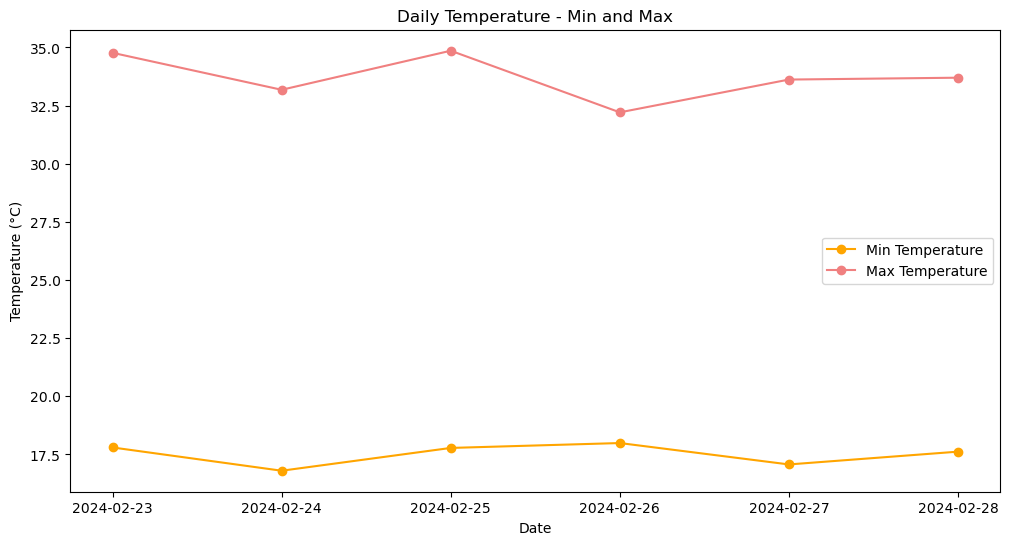

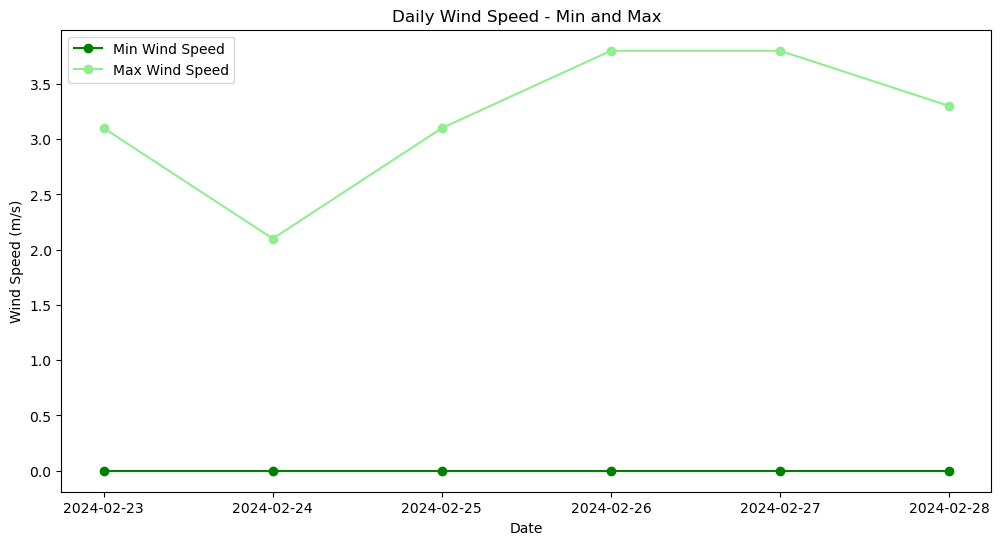

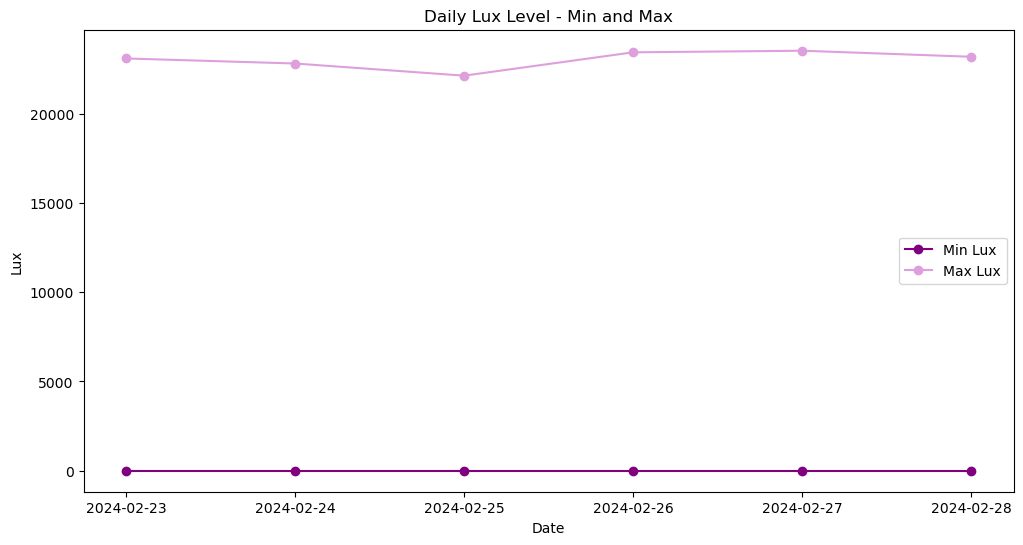

In [11]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and the Timestamp column is set as the index
# If not, you can set it using df.set_index('Timestamp', inplace=True)

# Convert the Timestamp to the date only
df.index = pd.to_datetime(df.index).date

# Group by date and find min and max for each column
min_values = df.groupby(df.index).min()
max_values = df.groupby(df.index).max()

# Plotting for Rainfall
plt.figure(figsize=(12, 6))
plt.plot(min_values.index, min_values['rainfall'], label='Min Rainfall', color='blue', marker='o')
plt.plot(max_values.index, max_values['rainfall'], label='Max Rainfall', color='lightblue', marker='o')
plt.title('Daily Rainfall - Min and Max')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()

# Plotting for Temperature
plt.figure(figsize=(12, 6))
plt.plot(min_values.index, min_values['temperature'], label='Min Temperature', color='orange', marker='o')
plt.plot(max_values.index, max_values['temperature'], label='Max Temperature', color='lightcoral', marker='o')
plt.title('Daily Temperature - Min and Max')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plotting for Speed
plt.figure(figsize=(12, 6))
plt.plot(min_values.index, min_values['speed'], label='Min Wind Speed', color='green', marker='o')
plt.plot(max_values.index, max_values['speed'], label='Max Wind Speed', color='lightgreen', marker='o')
plt.title('Daily Wind Speed - Min and Max')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.show()

# Plotting for Lux
plt.figure(figsize=(12, 6))
plt.plot(min_values.index, min_values['lux'], label='Min Lux', color='purple', marker='o')
plt.plot(max_values.index, max_values['lux'], label='Max Lux', color='plum', marker='o')
plt.title('Daily Lux Level - Min and Max')
plt.xlabel('Date')
plt.ylabel('Lux')
plt.legend()
plt.show()

# Highest Temperature

In [88]:
daily_max_illuminance_data = df.groupby(df.index.date)['temperature'].agg(['idxmax', 'max'])
daily_max_illuminance_data['Time'] = daily_max_illuminance_data['idxmax'].dt.strftime('%Y-%m-%d %H:%M:%S')
daily_max_illuminance_data[['Time', 'max']]
styled_df = daily_max_illuminance_data[['Time', 'max']].style.set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('font-weight', 'bold')]},
])
styled_df

,Time,max
2024-02-22,2024-02-22 17:06:16,27.270000
2024-02-23,2024-02-23 15:48:52,34.770000
2024-02-24,2024-02-24 15:09:24,33.180000
2024-02-25,2024-02-25 16:05:30,34.860000
2024-02-26,2024-02-26 14:41:28,32.210000
2024-02-27,2024-02-27 14:53:00,33.620000
2024-02-28,2024-02-28 14:07:11,33.700000
2024-02-29,2024-02-29 13:59:29,34.450000
2024-03-01,2024-03-01 15:21:07,33.550000


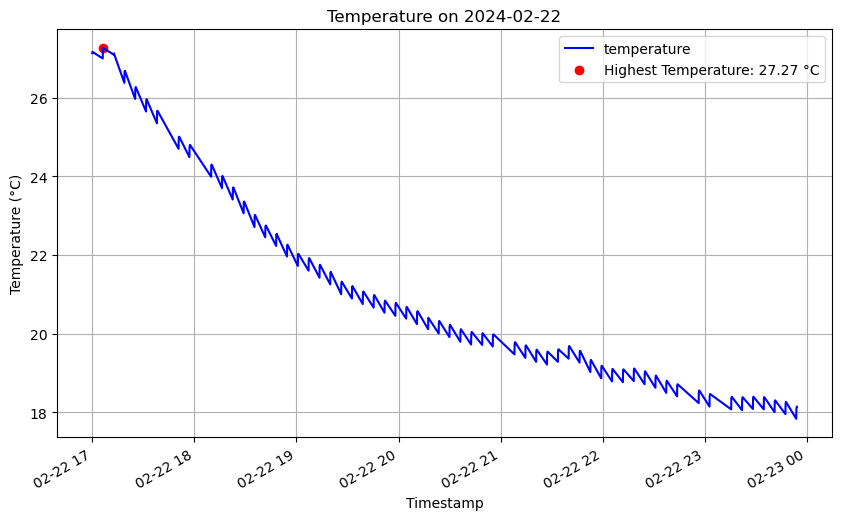

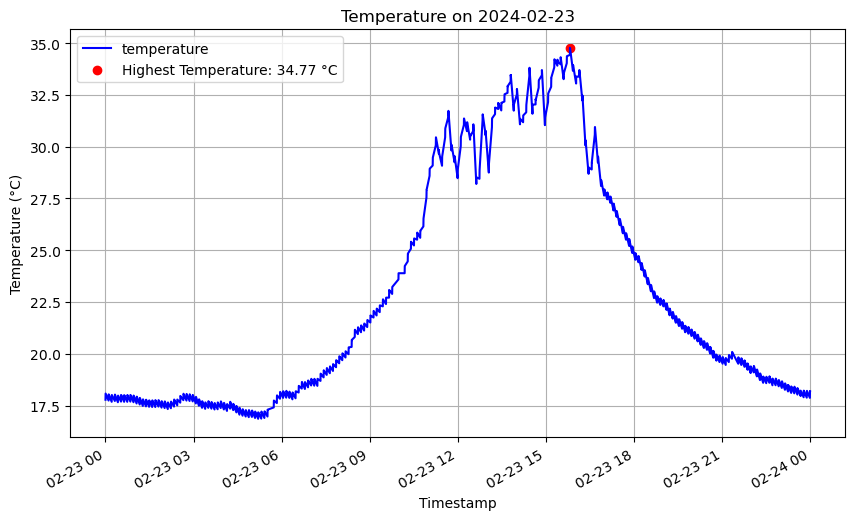

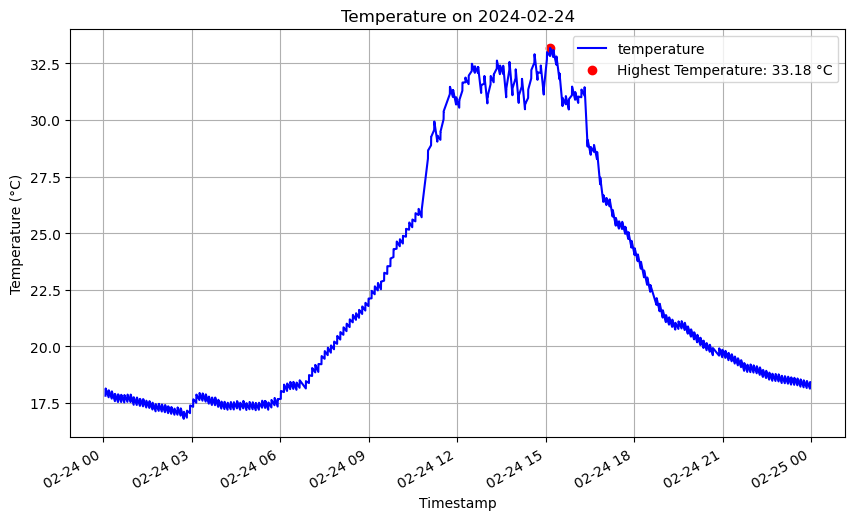

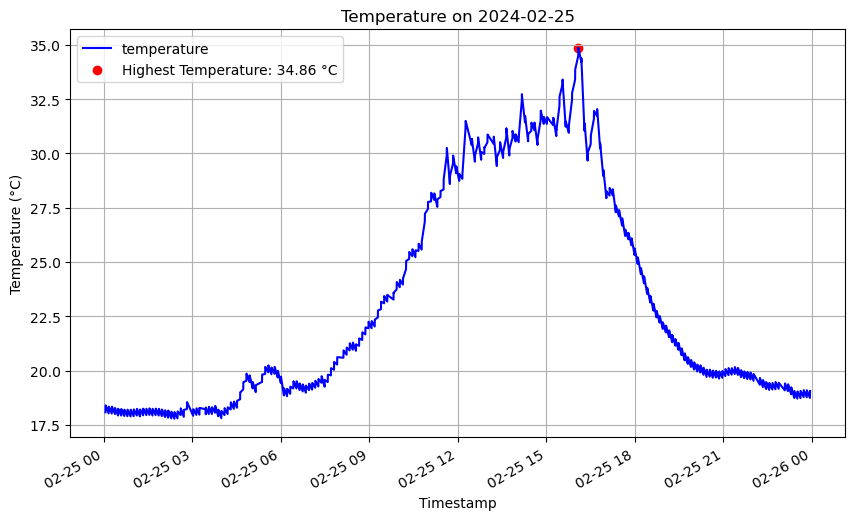

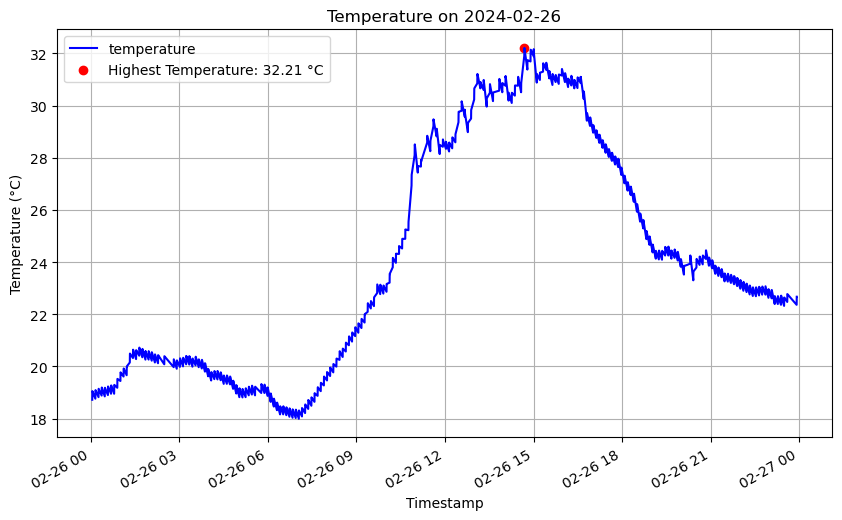

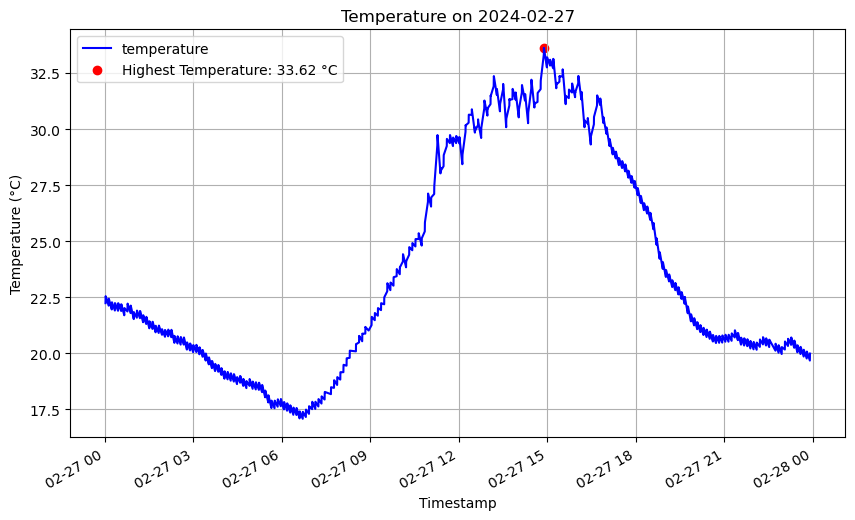

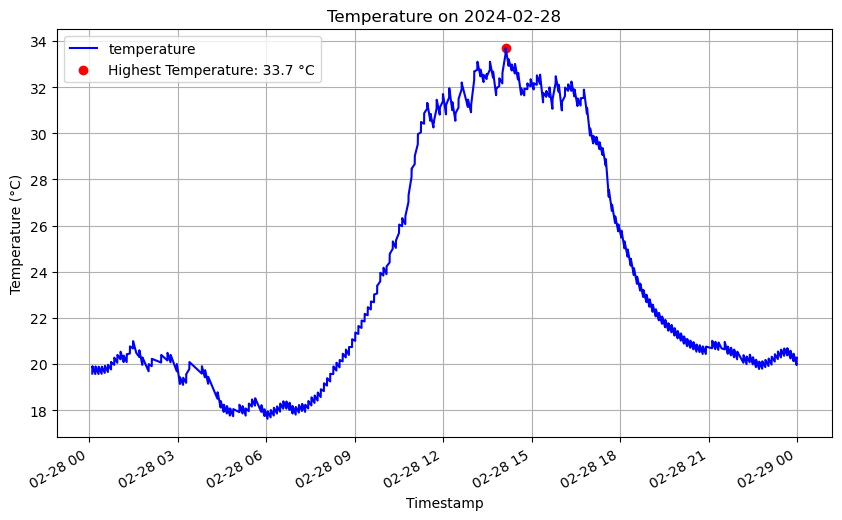

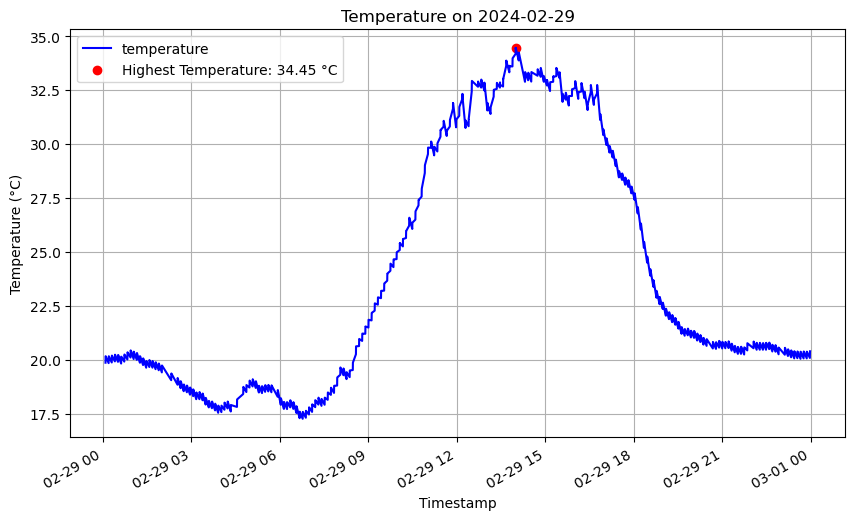

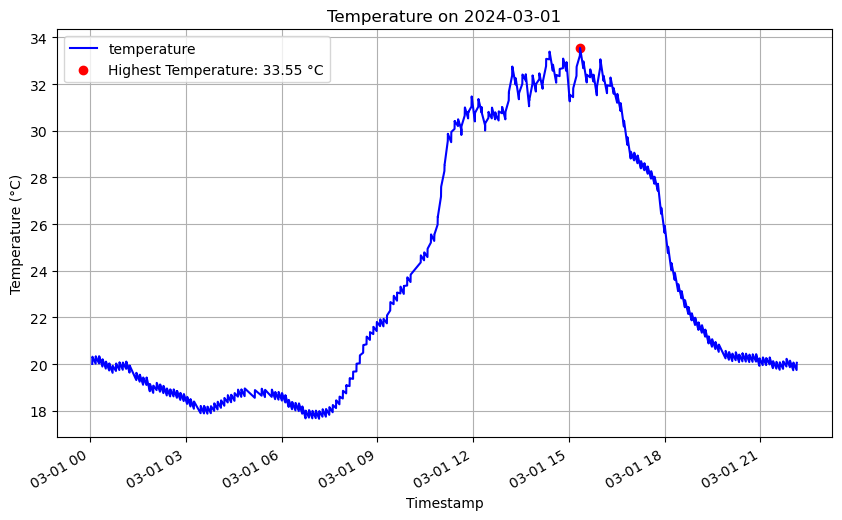

In [89]:
import matplotlib.pyplot as plt
def plot_temperature_for_date(date):
    daily_data = df['temperature'].loc[str(date)]
    daily_data.plot(figsize=(10, 6),  color='b')
    max_temp = daily_data.max()
    max_temp_timestamp = daily_data.idxmax()
    plt.scatter(max_temp_timestamp, max_temp, color='red', label=f'Highest Temperature: {max_temp} °C')
    plt.title(f'Temperature on {date}')
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)
    plt.legend()
    plt.show()
unique_dates = pd.Series(df.index.date).unique()
for date in unique_dates:
    plot_temperature_for_date(date)

# Highest Pressure

In [90]:
daily_max_illuminance_data = df.groupby(df.index.date)['pressure'].agg(['idxmax', 'max'])
daily_max_illuminance_data['Time'] = daily_max_illuminance_data['idxmax'].dt.strftime('%Y-%m-%d %H:%M:%S')
daily_max_illuminance_data[['Time', 'max']]
styled_df = daily_max_illuminance_data[['Time', 'max']].style.set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('font-weight', 'bold')]},
])
styled_df

,Time,max
2024-02-22,2024-02-22 23:28:23,905.270000
2024-02-23,2024-02-23 09:39:32,906.250000
2024-02-24,2024-02-24 10:09:55,905.800000
2024-02-25,2024-02-25 09:24:06,905.090000
2024-02-26,2024-02-26 10:13:55,905.220000
2024-02-27,2024-02-27 09:02:44,905.740000
2024-02-28,2024-02-28 09:52:16,905.530000
2024-02-29,2024-02-29 09:57:37,905.580000
2024-03-01,2024-03-01 10:02:52,906.960000


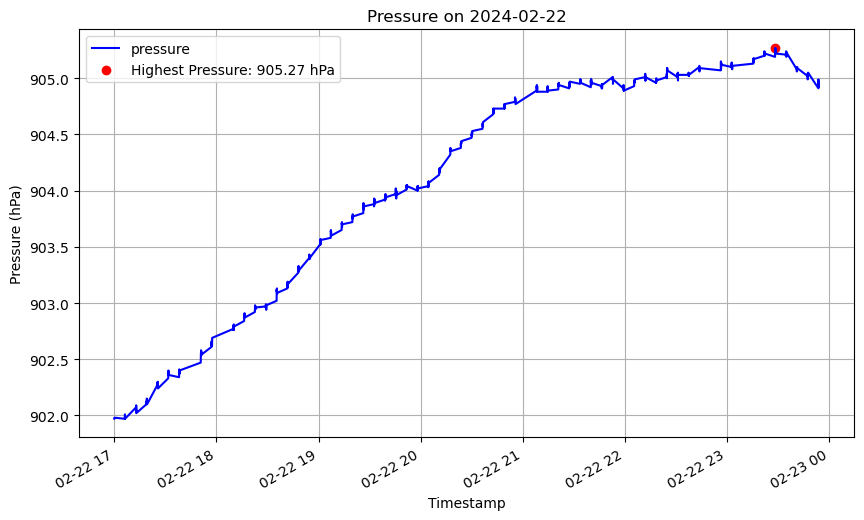

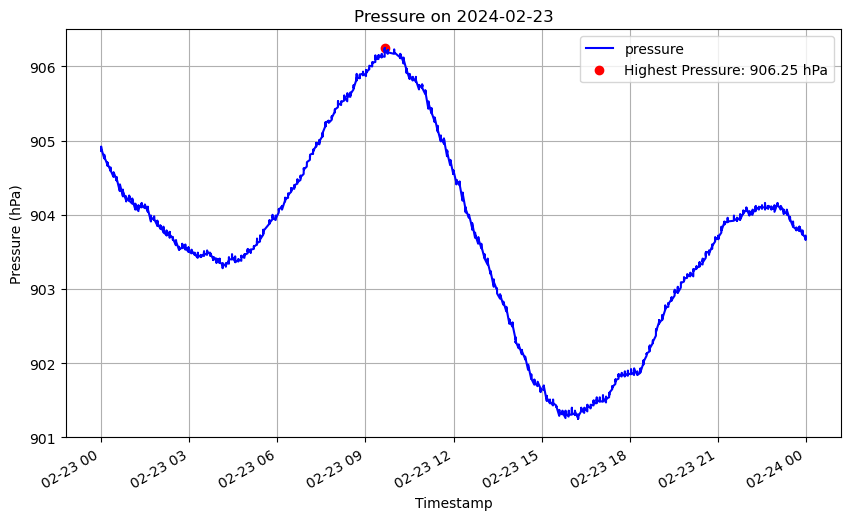

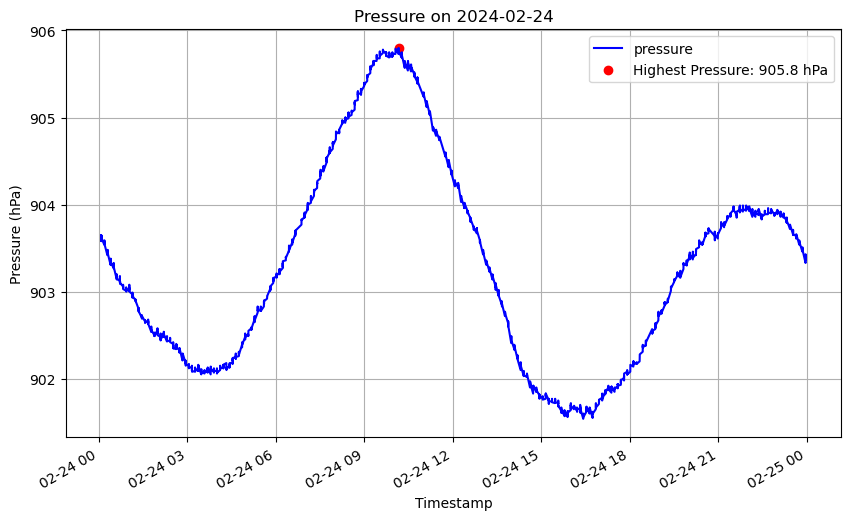

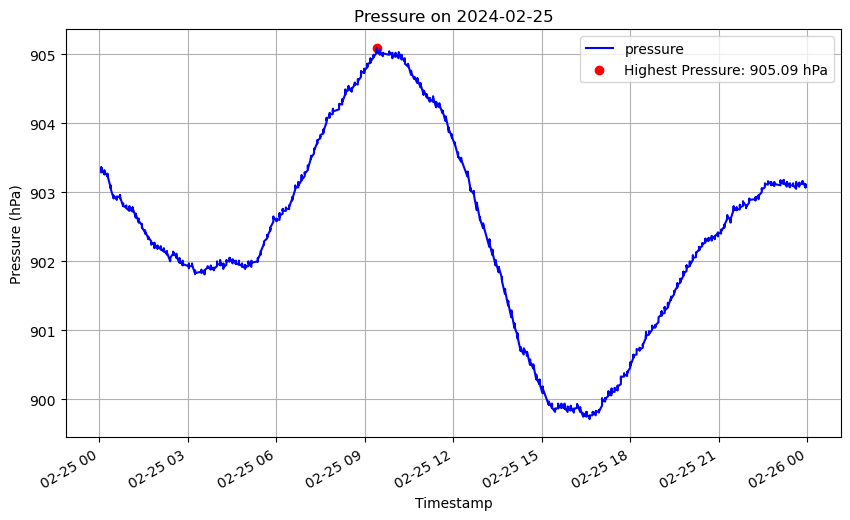

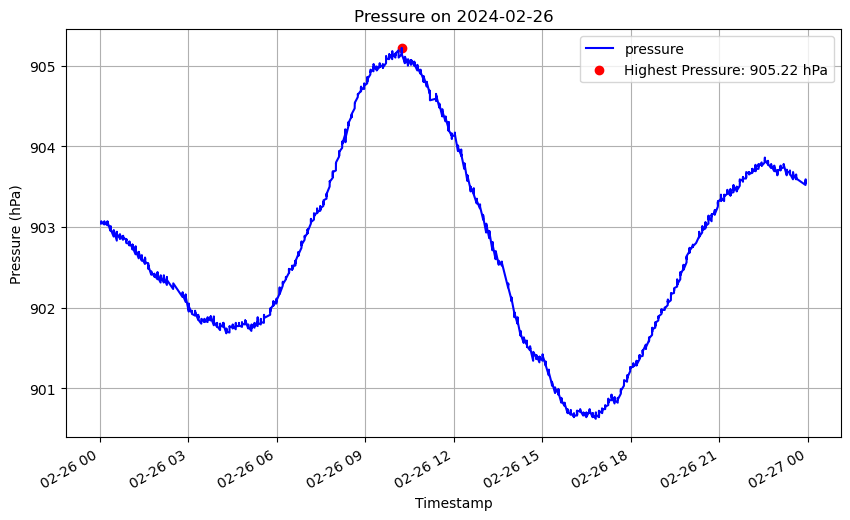

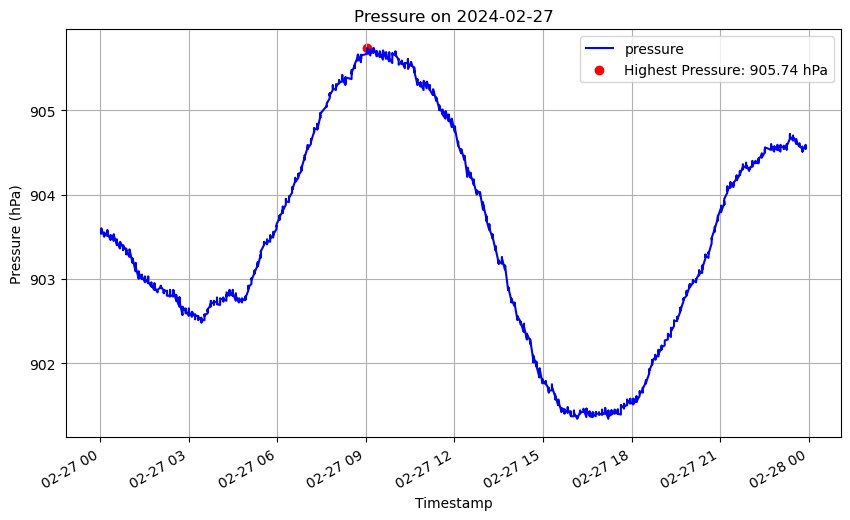

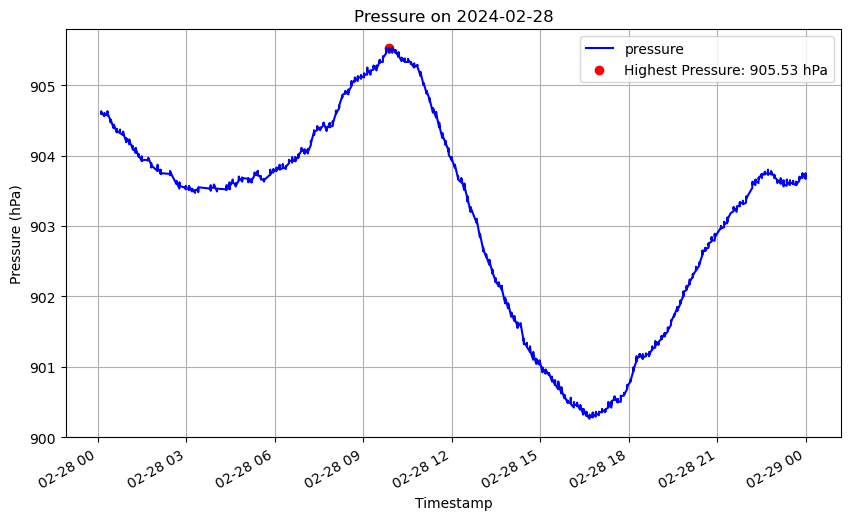

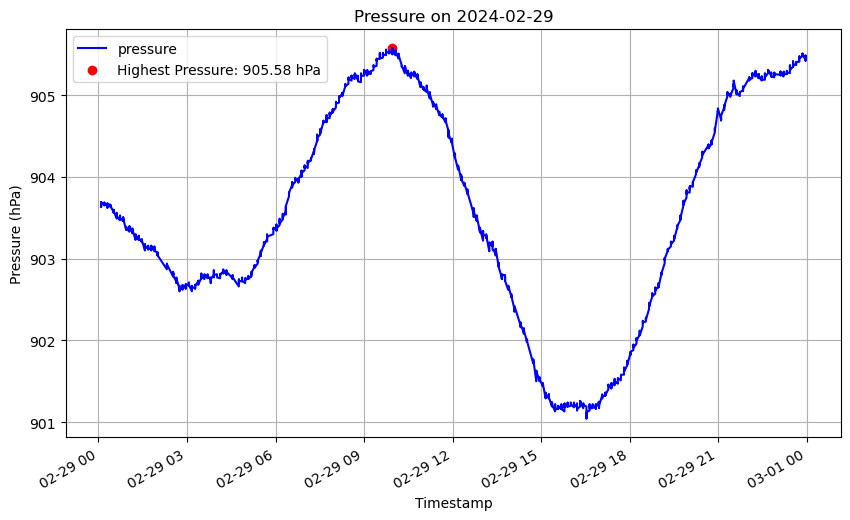

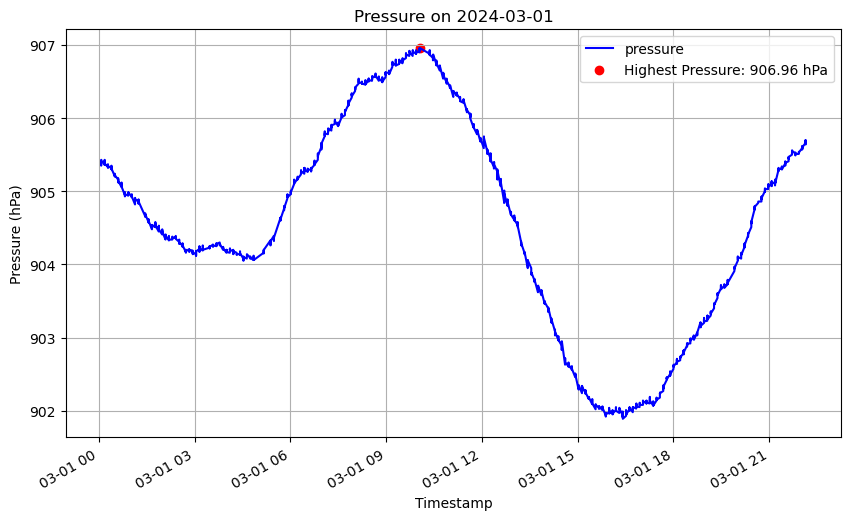

In [91]:
def plot_pressure_for_date(date):
    daily_data = df['pressure'].loc[str(date)]
    daily_data.plot(figsize=(10, 6), color='b')
    max_pressure = daily_data.max()
    max_pressure_timestamp = daily_data.idxmax()
    plt.scatter(max_pressure_timestamp, max_pressure, color='red', label=f'Highest Pressure: {max_pressure} hPa')
    plt.title(f'Pressure on {date}')
    plt.xlabel('Timestamp')
    plt.ylabel('Pressure (hPa)')
    plt.grid(True)
    plt.legend()
    plt.show()
unique_dates = pd.Series(df.index.date).unique()
for date in unique_dates:
    plot_pressure_for_date(date)

# Highest Humidity daily

In [92]:
daily_max_illuminance_data = df.groupby(df.index.date)['humidity'].agg(['idxmax', 'max'])
daily_max_illuminance_data['Time'] = daily_max_illuminance_data['idxmax'].dt.strftime('%Y-%m-%d %H:%M:%S')
daily_max_illuminance_data[['Time', 'max']]
styled_df = daily_max_illuminance_data[['Time', 'max']].style.set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('font-weight', 'bold')]},
])
styled_df

,Time,max
2024-02-22,2024-02-22 23:53:37,96.560000
2024-02-23,2024-02-23 01:48:13,98.910000
2024-02-24,2024-02-24 23:57:34,98.310000
2024-02-25,2024-02-25 00:54:47,100.000000
2024-02-26,2024-02-26 00:02:39,95.410000
2024-02-27,2024-02-27 21:59:16,94.390000
2024-02-28,2024-02-28 04:53:07,94.750000
2024-02-29,2024-02-29 21:44:07,100.000000
2024-03-01,2024-03-01 00:04:07,100.000000


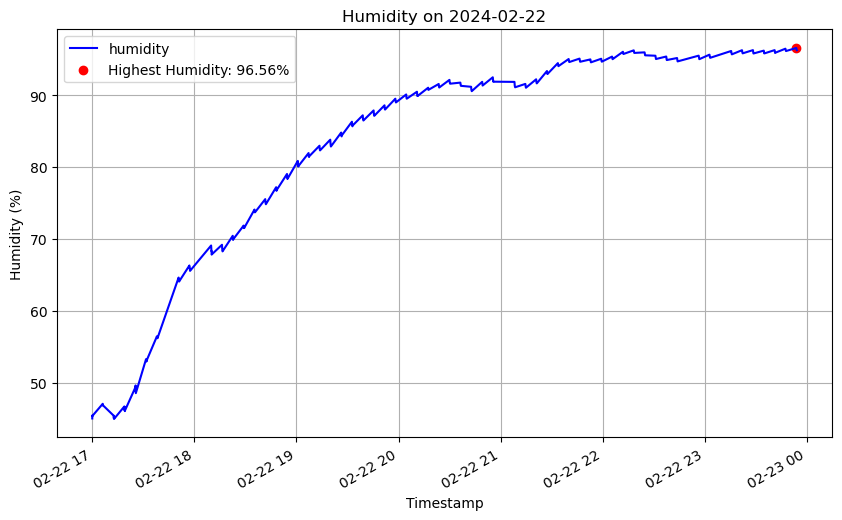

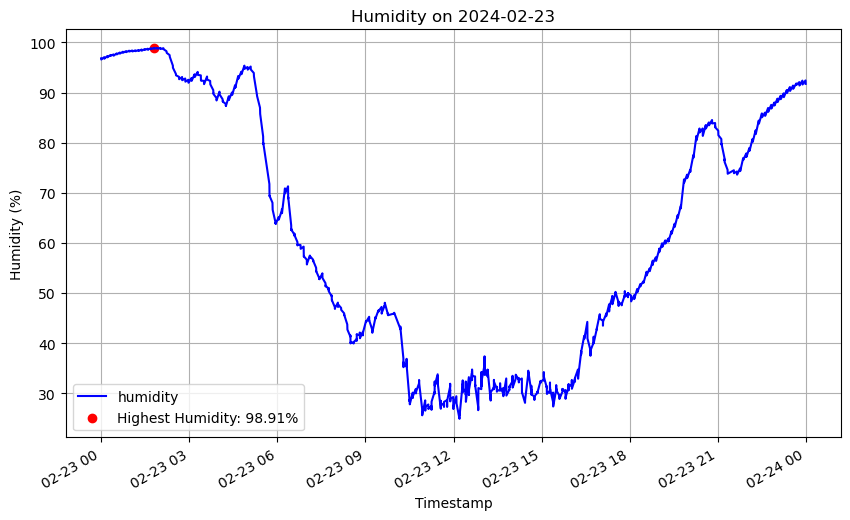

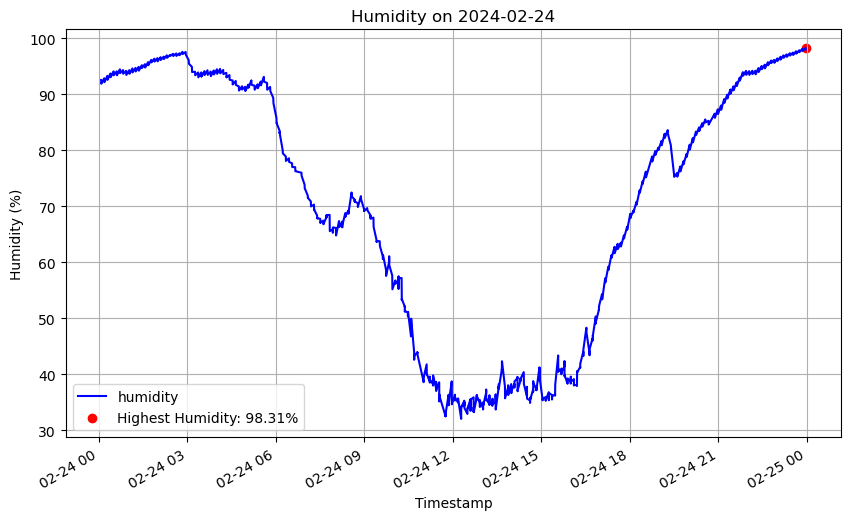

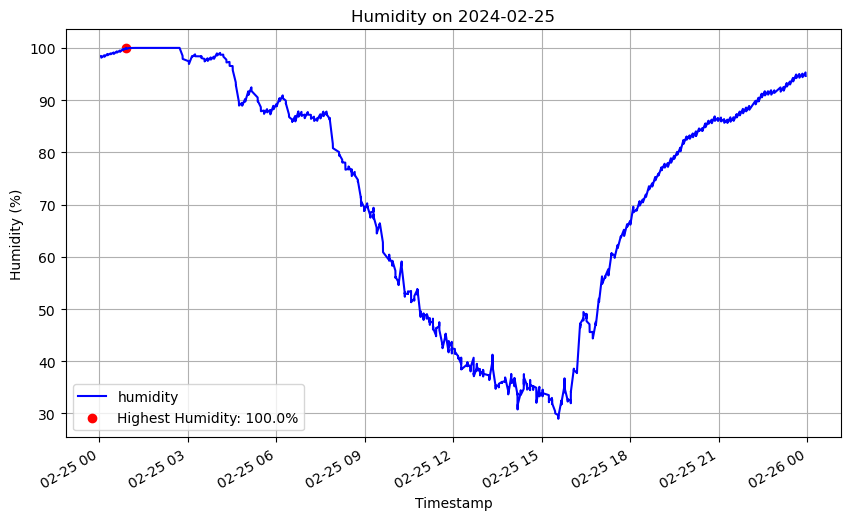

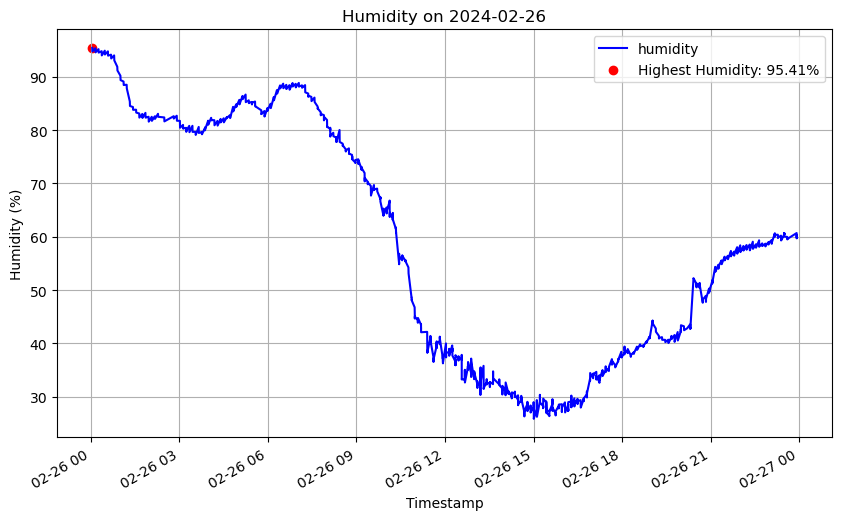

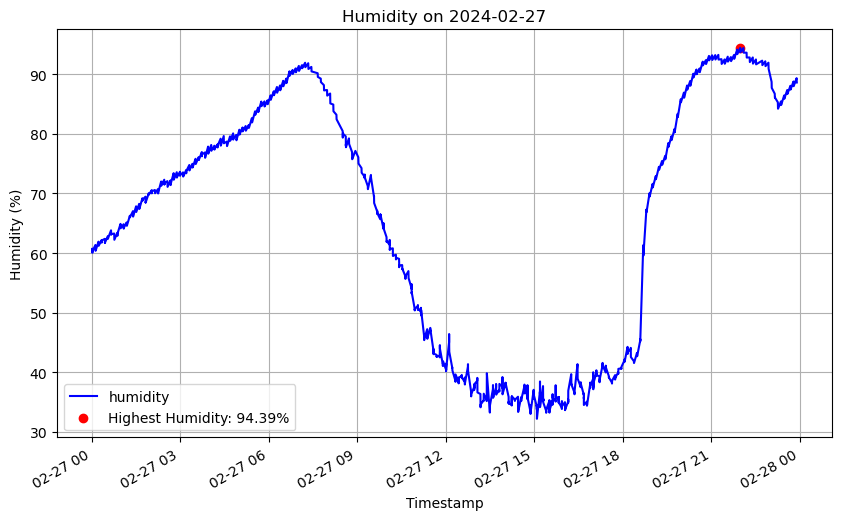

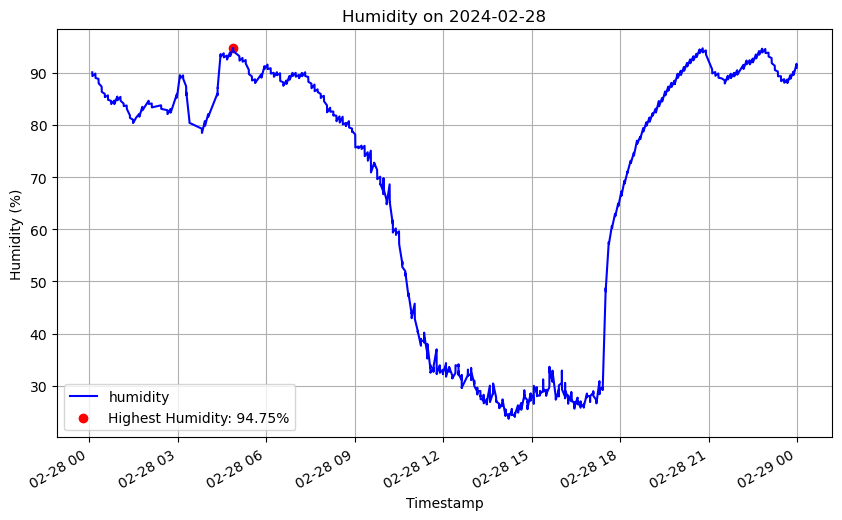

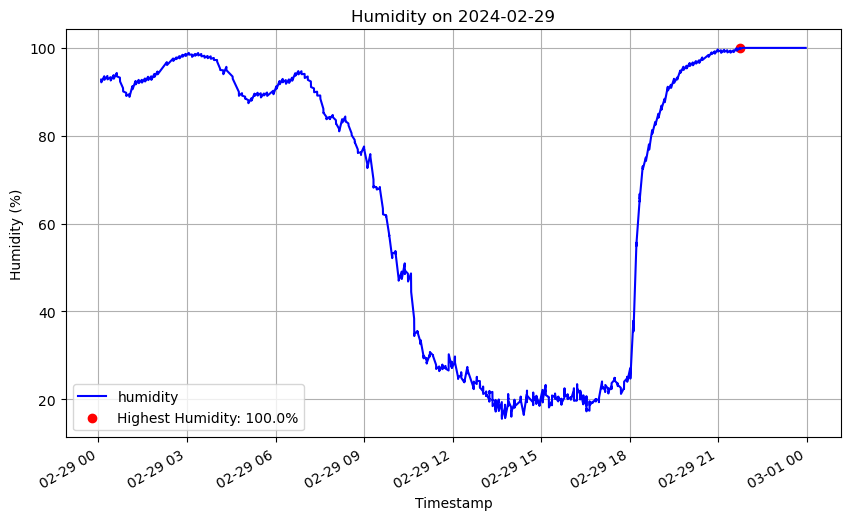

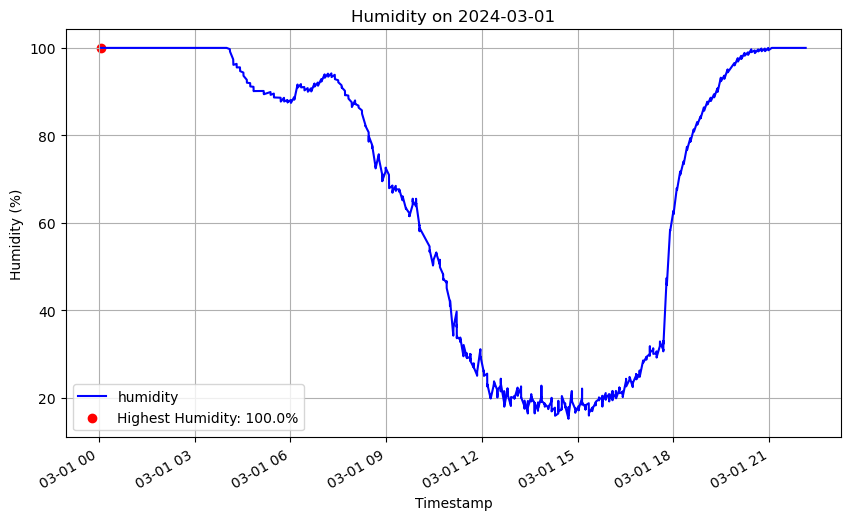

In [95]:
def plot_humidity_for_date(date):
    daily_data = df['humidity'].loc[str(date)]
    daily_data.plot(figsize=(10, 6), color='b')
    max_humidity = daily_data.max()
    max_humidity_timestamp = daily_data.idxmax()
    plt.scatter(max_humidity_timestamp, max_humidity, color='red', label=f'Highest Humidity: {max_humidity}%')
    plt.title(f'Humidity on {date}')
    plt.xlabel('Timestamp')
    plt.ylabel('Humidity (%)')
    plt.grid(True)
    plt.legend()
    plt.show()
unique_dates = pd.Series(df.index.date).unique()
for date in unique_dates:
    plot_humidity_for_date(date)

# Highest Lux (light intensity)

In [98]:
daily_max_illuminance_data = df.groupby(df.index.date)['lux'].agg(['idxmax', 'max'])
daily_max_illuminance_data['Time'] = daily_max_illuminance_data['idxmax'].dt.strftime('%Y-%m-%d %H:%M:%S')
daily_max_illuminance_data[['Time', 'max']]
styled_df = daily_max_illuminance_data[['Time', 'max']].style.set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('font-weight', 'bold')]},
])
styled_df

,Time,max
2024-02-22,2024-02-22 17:00:03,6790.350000
2024-02-23,2024-02-23 13:09:30,23097.600000
2024-02-24,2024-02-24 14:11:47,22814.670000
2024-02-25,2024-02-25 13:26:13,22133.140000
2024-02-26,2024-02-26 14:09:26,23441.360000
2024-02-27,2024-02-27 13:30:10,23530.750000
2024-02-28,2024-02-28 14:07:13,23192.060000
2024-02-29,2024-02-29 13:27:29,23342.290000
2024-03-01,2024-03-01 13:32:39,23097.140000


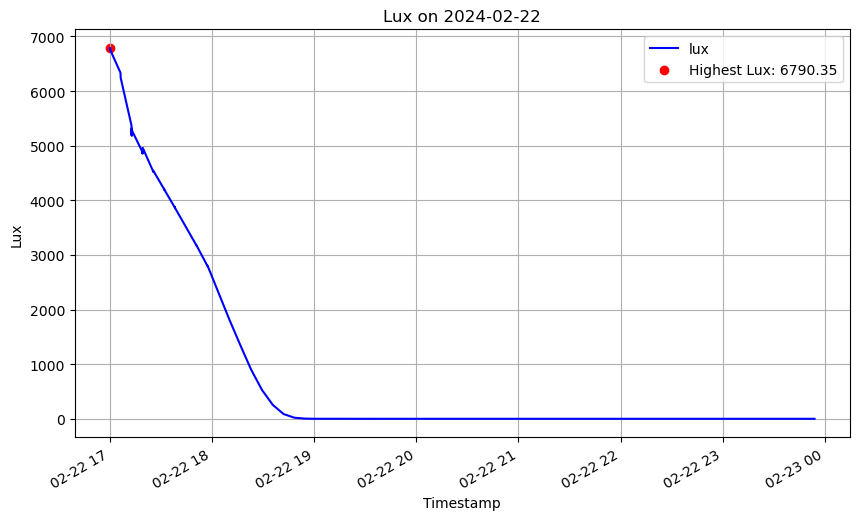

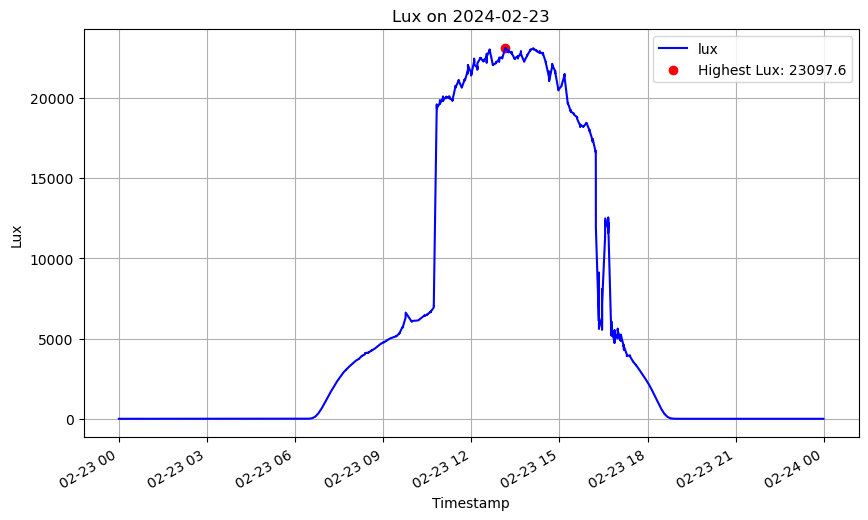

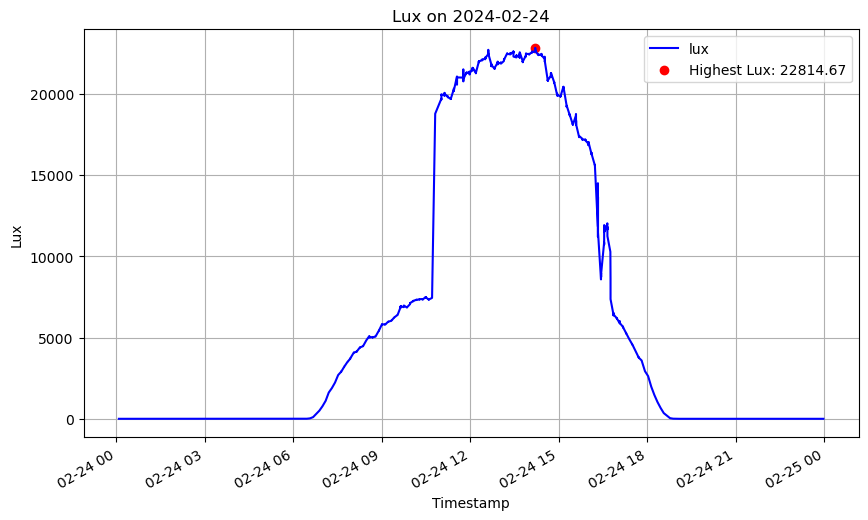

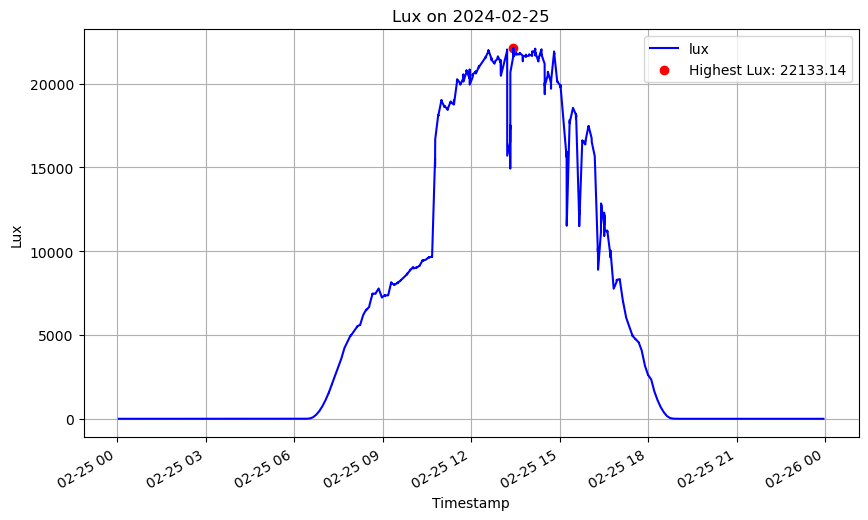

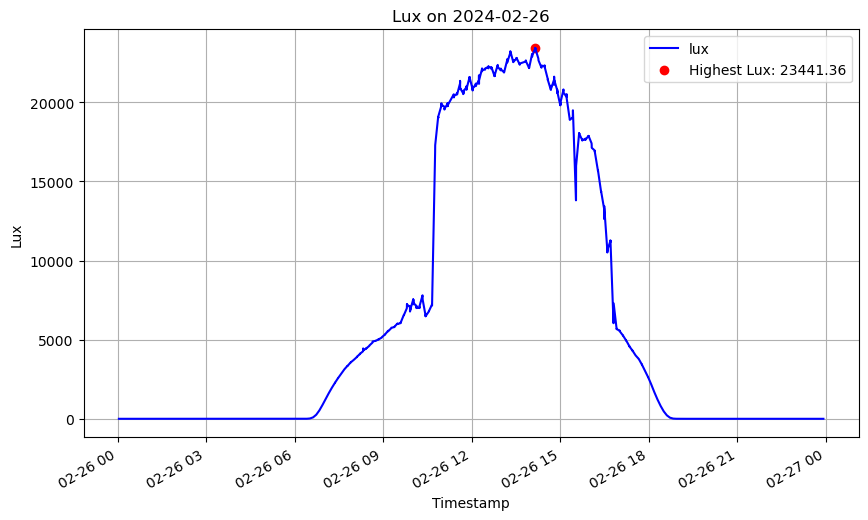

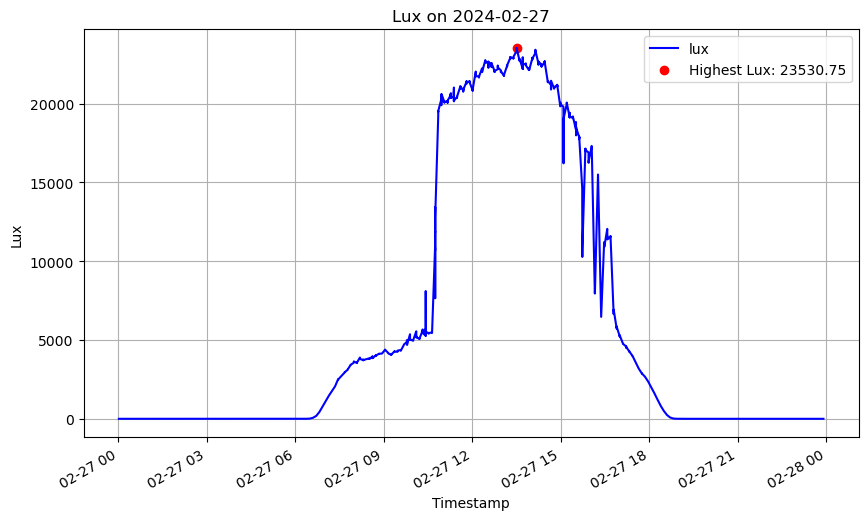

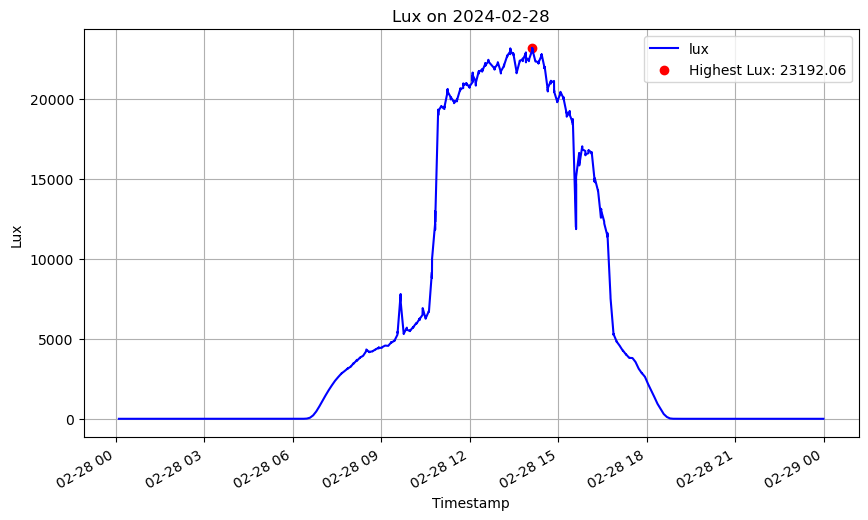

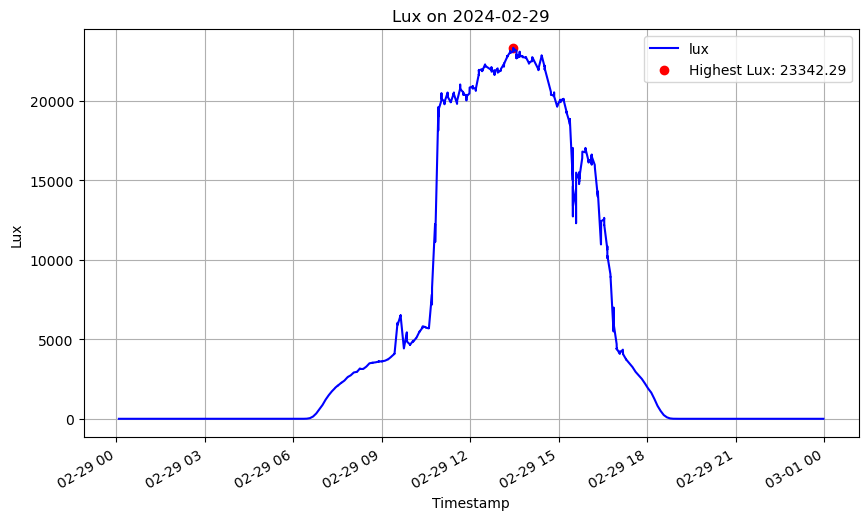

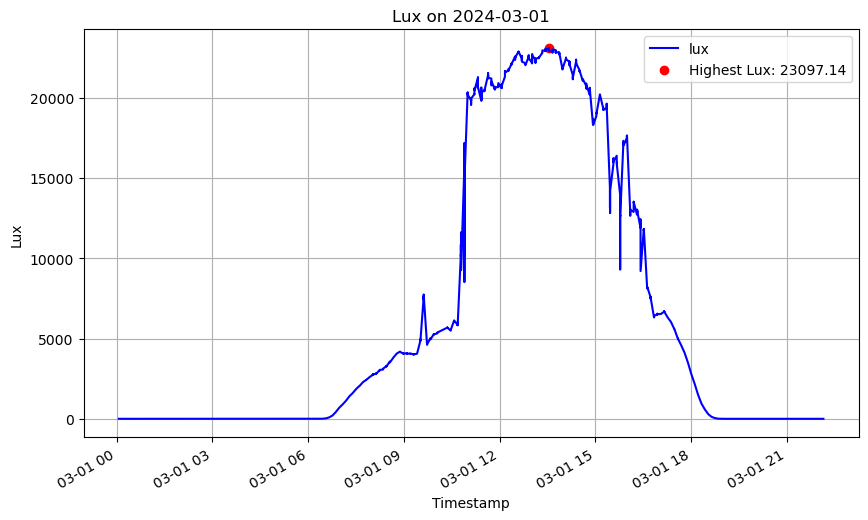

In [100]:
def plot_lux_for_date(date):
    daily_data = df['lux'].loc[str(date)]
    daily_data.plot(figsize=(10, 6), color='b')
    max_lux = daily_data.max()
    max_lux_timestamp = daily_data.idxmax()
    plt.scatter(max_lux_timestamp, max_lux, color='red', label=f'Highest Lux: {max_lux}')
    plt.title(f'Lux on {date}')
    plt.xlabel('Timestamp')
    plt.ylabel('Lux')
    plt.grid(True)
    plt.legend()
    plt.show()
unique_dates = pd.Series(df.index.date).unique()
for date in unique_dates:
    plot_lux_for_date(date)

# Highest Wind Speed

In [102]:
daily_max_illuminance_data = df.groupby(df.index.date)['speed'].agg(['idxmax', 'max'])
daily_max_illuminance_data['Time'] = daily_max_illuminance_data['idxmax'].dt.strftime('%Y-%m-%d %H:%M:%S')
daily_max_illuminance_data[['Time', 'max']]
styled_df = daily_max_illuminance_data[['Time', 'max']].style.set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('font-weight', 'bold')]},
])
styled_df

,Time,max
2024-02-22,2024-02-22 17:19:12,0.800000
2024-02-23,2024-02-23 12:56:57,3.100000
2024-02-24,2024-02-24 12:36:23,2.100000
2024-02-25,2024-02-25 12:54:23,3.100000
2024-02-26,2024-02-26 12:34:02,3.800000
2024-02-27,2024-02-27 02:34:22,3.800000
2024-02-28,2024-02-28 13:22:36,3.300000
2024-02-29,2024-02-29 13:27:31,3.100000
2024-03-01,2024-03-01 12:41:39,4.000000


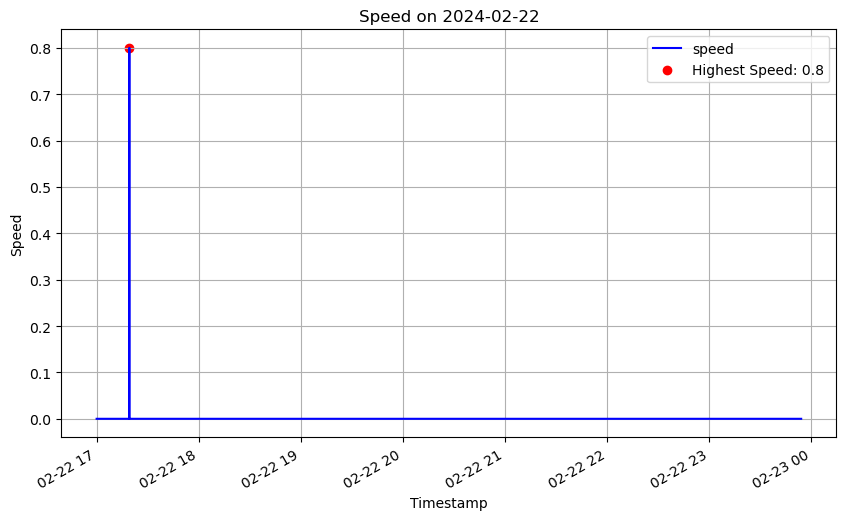

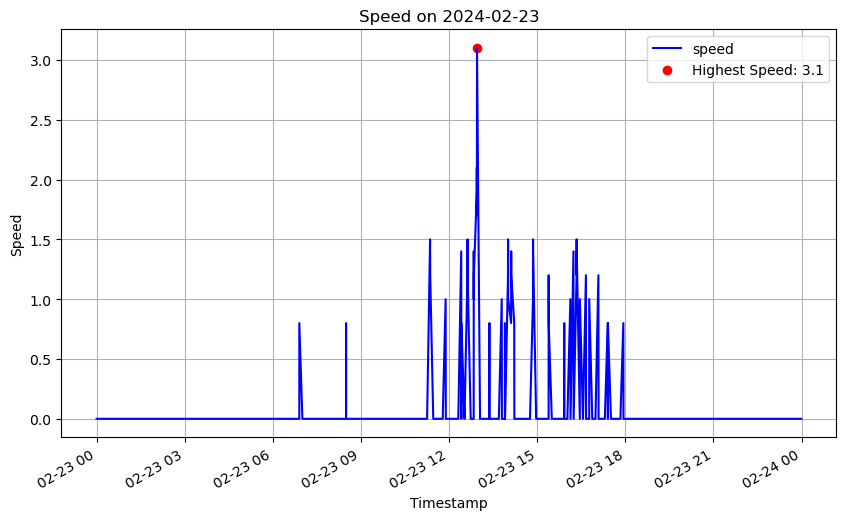

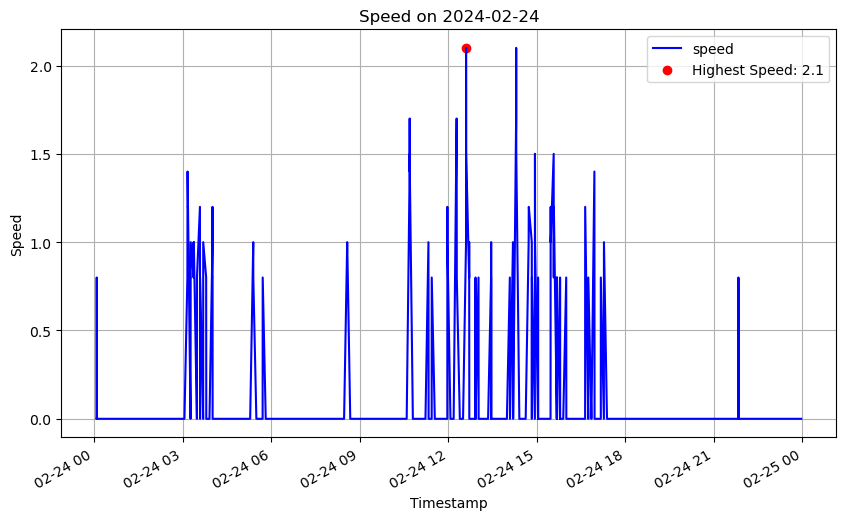

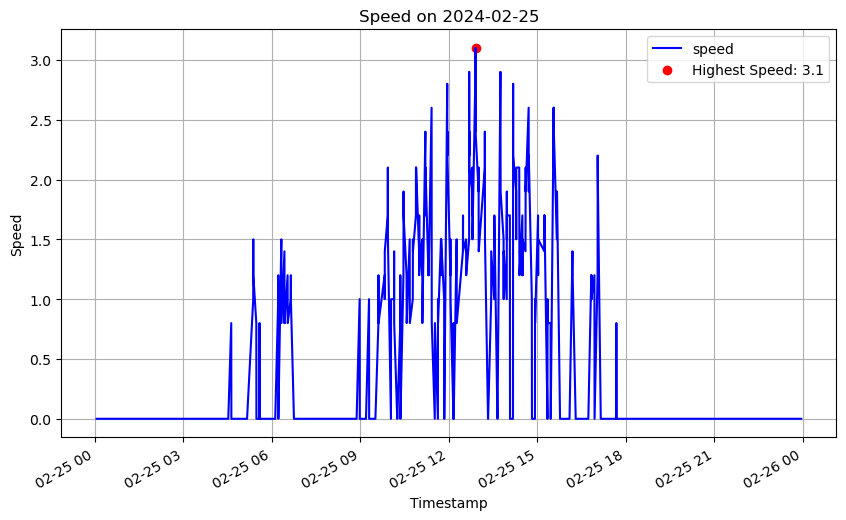

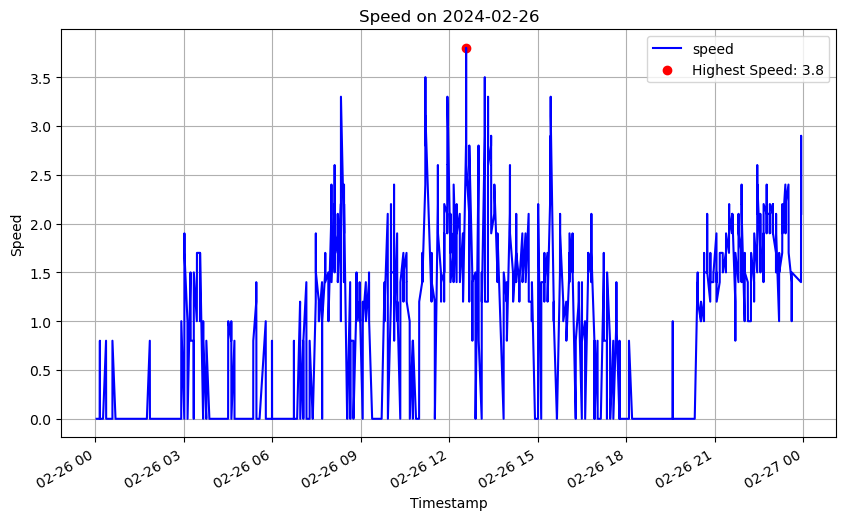

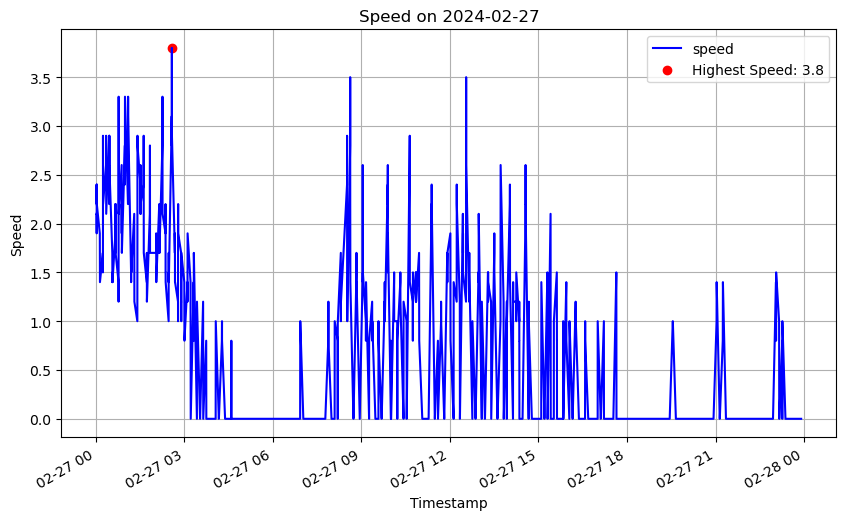

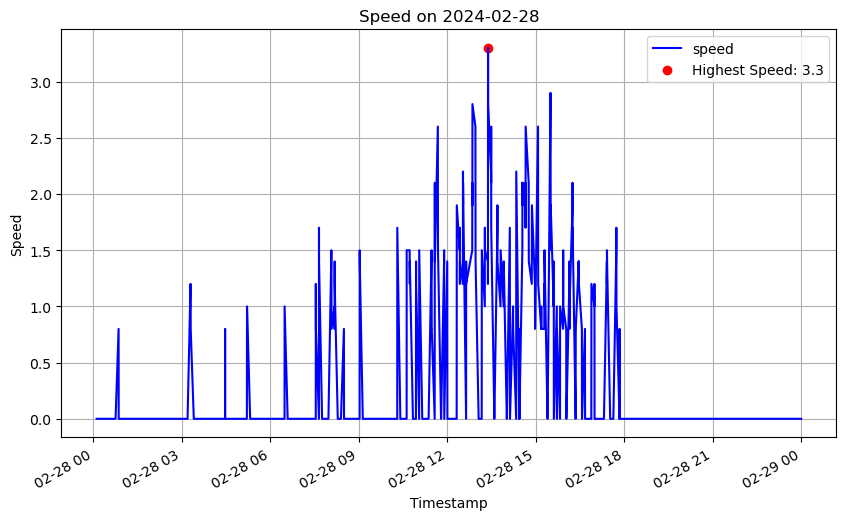

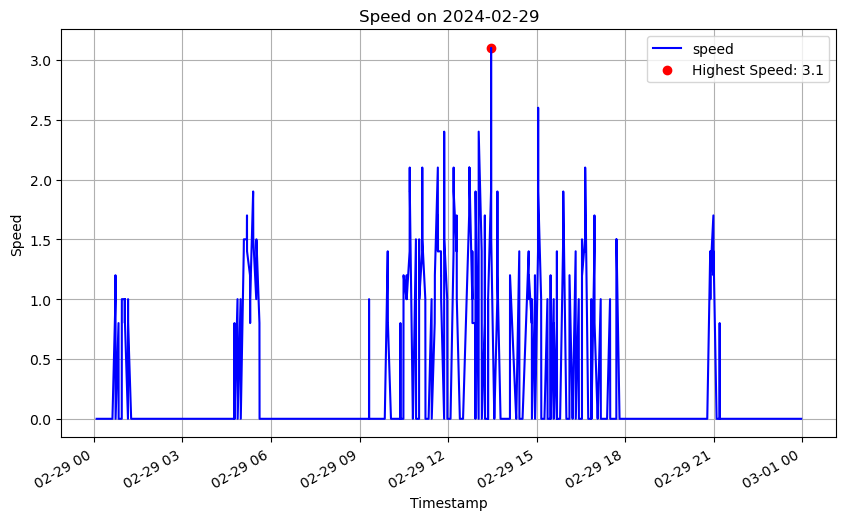

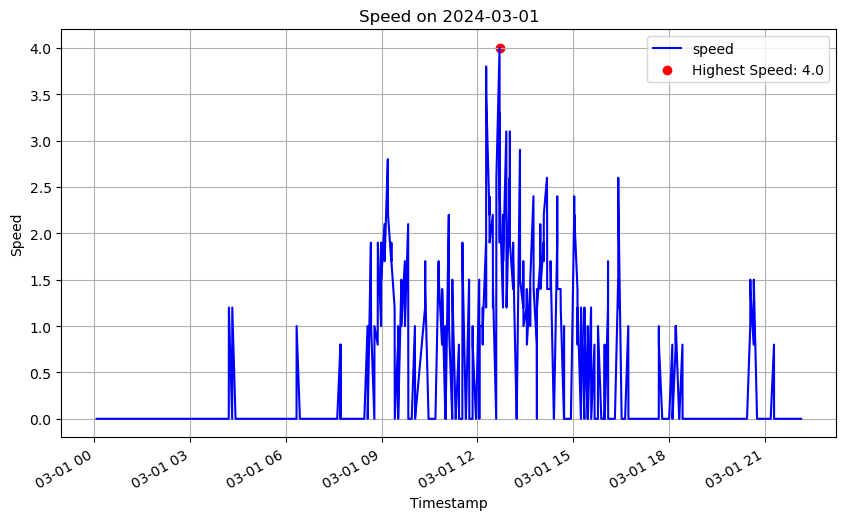

In [103]:
def plot_speed_for_date(date):
    daily_data = df['speed'].loc[str(date)]
    daily_data.plot(figsize=(10, 6), color='b')
    max_speed = daily_data.max()
    max_speed_timestamp = daily_data.idxmax()
    plt.scatter(max_speed_timestamp, max_speed, color='red', label=f'Highest Speed: {max_speed}')
    plt.title(f'Speed on {date}')
    plt.xlabel('Timestamp')
    plt.ylabel('Speed')
    plt.grid(True)
    plt.legend()
    plt.show()
unique_dates = pd.Series(df.index.date).unique()
for date in unique_dates:
    plot_speed_for_date(date)